# Waymo Open Dataset Exploration

This notebook demonstrates how to extract and explore one frame of data from a Waymo Open Dataset TFRecord file.

In [ ]:
# Import required libraries
import tensorflow as tf
from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset.utils import frame_utils
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

: 

In [4]:
from waymo_open_dataset import dataset_pb2
def parse_range_image_and_camera_projection_flow(
    frame: dataset_pb2.Frame):
  """Parse range images and camera projections given a frame.

  Args:
    frame: open dataset frame proto

  Returns:
    range_images: A dict of {laser_name,
      [range_image_first_return, range_image_second_return]}.
    camera_projections: A dict of {laser_name,
      [camera_projection_from_first_return,
      camera_projection_from_second_return]}.
    seg_labels: segmentation labels, a dict of {laser_name,
      [seg_label_first_return, seg_label_second_return]}
    range_image_top_pose: range image pixel pose for top lidar.
  """
  range_images = {}
  camera_projections = {}
  seg_labels = {}
  range_image_top_pose: dataset_pb2.MatrixFloat = dataset_pb2.MatrixFloat()
  for laser in frame.lasers:
    if len(laser.ri_return1.range_image_flow_compressed) > 0:  # pylint: disable=g-explicit-length-test
      range_image_str_tensor = tf.io.decode_compressed(
          laser.ri_return1.range_image_flow_compressed, 'ZLIB')
      ri = dataset_pb2.MatrixFloat()
      ri.ParseFromString(bytearray(range_image_str_tensor.numpy()))
      range_images[laser.name] = [ri]

      if laser.name == dataset_pb2.LaserName.TOP:
        range_image_top_pose_str_tensor = tf.io.decode_compressed(
            laser.ri_return1.range_image_pose_compressed, 'ZLIB')
        range_image_top_pose = dataset_pb2.MatrixFloat()
        range_image_top_pose.ParseFromString(
            bytearray(range_image_top_pose_str_tensor.numpy()))

      camera_projection_str_tensor = tf.io.decode_compressed(
          laser.ri_return1.camera_projection_compressed, 'ZLIB')
      cp = dataset_pb2.MatrixInt32()
      cp.ParseFromString(bytearray(camera_projection_str_tensor.numpy()))
      camera_projections[laser.name] = [cp]

      if len(laser.ri_return1.segmentation_label_compressed) > 0:  # pylint: disable=g-explicit-length-test
        seg_label_str_tensor = tf.io.decode_compressed(
            laser.ri_return1.segmentation_label_compressed, 'ZLIB')
        seg_label = dataset_pb2.MatrixInt32()
        seg_label.ParseFromString(bytearray(seg_label_str_tensor.numpy()))
        seg_labels[laser.name] = [seg_label]
    if len(laser.ri_return2.range_image_flow_compressed) > 0:  # pylint: disable=g-explicit-length-test
      range_image_str_tensor = tf.io.decode_compressed(
          laser.ri_return2.range_image_flow_compressed, 'ZLIB')
      ri = dataset_pb2.MatrixFloat()
      ri.ParseFromString(bytearray(range_image_str_tensor.numpy()))
      range_images[laser.name].append(ri)

      camera_projection_str_tensor = tf.io.decode_compressed(
          laser.ri_return2.camera_projection_compressed, 'ZLIB')
      cp = dataset_pb2.MatrixInt32()
      cp.ParseFromString(bytearray(camera_projection_str_tensor.numpy()))
      camera_projections[laser.name].append(cp)

      if len(laser.ri_return2.segmentation_label_compressed) > 0:  # pylint: disable=g-explicit-length-test
        seg_label_str_tensor = tf.io.decode_compressed(
            laser.ri_return2.segmentation_label_compressed, 'ZLIB')
        seg_label = dataset_pb2.MatrixInt32()
        seg_label.ParseFromString(bytearray(seg_label_str_tensor.numpy()))
        seg_labels[laser.name].append(seg_label)
  return range_images, camera_projections, seg_labels, range_image_top_pose

2024-10-21 23:09:30.315611: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46865 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1d:00.0, compute capability: 8.6
2024-10-21 23:09:30.317753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46865 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:1f:00.0, compute capability: 8.6
2024-10-21 23:09:30.318273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46865 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:21:00.0, compute capability: 8.6
2024-10-21 23:09:30.318746: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 46865 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:22:00.0, 

(64, 2650, 3)
tf.Tensor([6877.618   9123.559    275.70325], shape=(3,), dtype=float32)


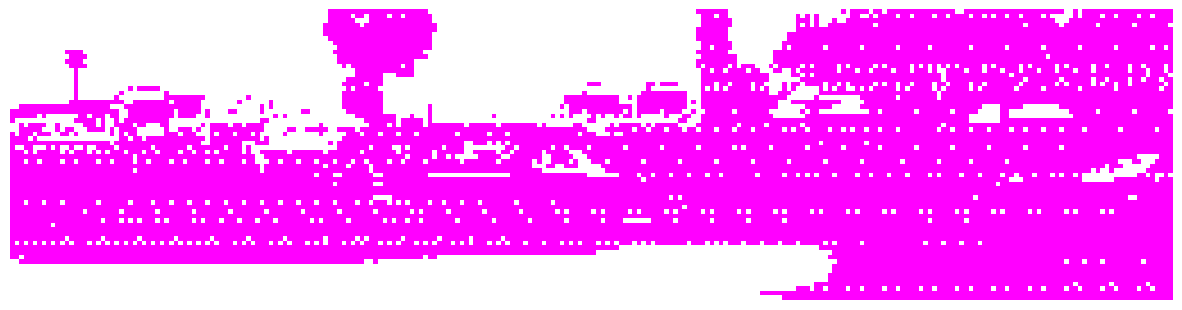

In [6]:
# Set the path to your TFRecord file
tfrecord_path = '/media/staging1/dhwang/Waymo/archived_files/scene_flow/validation/'
file_list = glob.glob(
        os.path.join(os.path.abspath(tfrecord_path), "*.tfrecord")
    )
# Read the TFRecord file
dataset = tf.data.TFRecordDataset(file_list[0], compression_type='')

# Get the first frame
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    break
# Extract point cloud data

#print((frame.lasers[0].ri_return1.range_image_flow_compressed))
range_images, camera_projections, seg_labels, range_image_top_pose = parse_range_image_and_camera_projection_flow(frame)

range_dictionary = frame_utils.convert_range_image_to_cartesian(frame, range_images, range_image_top_pose, keep_polar_features=False, ri_index=0)

# pcs, _ = frame_utils.convert_range_image_to_point_cloud(frame,
#                                      range_images,
#                                      camera_projections,
#                                      range_image_top_pose,
#                                      keep_polar_features=True,
#                                      ri_index=0)
#  # 3d points in vehicle frame.
# points_all = np.concatenate(pcs, axis=0)
# points_all_ri2 = np.concatenate(pcs2, axis=0)

# points_all = np.concatenate([points_all, points_all_ri2], axis=0)

# velodyne = np.c_[points_all[:, 3:6], points_all[:, 1]]
# velodyne = velodyne.reshape((velodyne.shape[0] * velodyne.shape[1]))


print(range_dictionary[1].shape)
print(range_dictionary[1][0][0])
plt.figure(figsize=(15, 10))
#transpose the image so channel is the first dimension rather than last

#before showing the image, first normalize the color channels within 0 and 255

image = range_dictionary[1].numpy()
image = (image - image.min()) / (image.max() - image.min())
plt.imshow(range_dictionary[1].numpy()[:,:256,:])

plt.axis('off')
plt.show()


In [4]:
# Set the path to your TFRecord file
tfrecord_path1 = '/media/staging1/dhwang/Waymo/archived_files/training/'
file_list1 = glob.glob(
        os.path.join(os.path.abspath(tfrecord_path1), "*.tfrecord")
    )
# Read the TFRecord file
dataset1 = tf.data.TFRecordDataset(file_list1[0], compression_type='')

# Get the first frame
for data1 in dataset1:
    frame1 = open_dataset.Frame()
    frame1.ParseFromString(bytearray(data1.numpy()))
    break
# Extract point cloud data
print((frame1.lasers[0].ri_return1.range_image_flow_compressed))
# range_images1, camera_projections1, seg_labels1, range_image_top_pose1 = frame_utils.parse_range_image_and_camera_projection(frame1)

range_images1, camera_projections1, seg_labels1, range_image_top_pose1 = parse_range_image_and_camera_projection_flow(frame1)
range_image_dict1 = frame_utils.convert_range_image_to_cartesian(frame1,
                                     range_images1,
                                     range_image_top_pose1,
                                     ri_index=0)

print(range_image_dict1[1].shape)
print(range_image_dict1[1][0][0])


print(range_image_dict1[1].numpy().shape)
plt.figure(figsize=(15, 10))
#transpose the image so channel is the first dimension rather than last
plt.imshow(range_image_dict1[1].numpy()[:,:256,:])

plt.axis('off')
plt.show()



# points1, cp_points1 = frame_utils.convert_range_image_to_point_cloud(
#     frame1,
#     range_images1,
#     camera_projections1,
#     range_image_top_pose1,
#     keep_polar_features=True
# )

# # Concatenate points from all lasers
# points_all1 = np.concatenate(points1, axis=0)

# print(f"Point cloud shape: {points_all1.shape}")


b''


2024-10-07 10:15:19.749558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 0 values, but the requested shape has 1 [Op:Reshape]

In [7]:
import open3d as o3d
def convert_range_image_to_point_cloud_with_flow(frame, range_images, flow_images, camera_projections, range_image_top_pose, ri_index=0):
    """Convert range images to point cloud with corresponding flow vectors.

    Args:
    frame: open dataset frame
    range_images: A dict of {laser_name, [range_image_first_return, range_image_second_return]}.
    flow_images: A dict of {laser_name, [flow_image_first_return, flow_image_second_return]}.
    camera_projections: A dict of {laser_name, [camera_projection_from_first_return, camera_projection_from_second_return]}.
    range_image_top_pose: range image pixel pose for top lidar.
    ri_index: 0 for the first return, 1 for the second return.

    Returns:
    points: {[N, 5]} list of 3d lidar points with intensity and elongation.
    flow_vectors: {[N, 3]} list of 3d flow vectors corresponding to each point.
    """
    calibrations = sorted(frame.context.laser_calibrations, key=lambda c: c.name)
    points = []
    flow_vectors = []

    cartesian_range_images = frame_utils.convert_range_image_to_cartesian(
      frame, range_images, range_image_top_pose, ri_index)
    
    cartesian_flow_images = frame_utils.convert_range_image_to_cartesian(
      frame, flow_images, range_image_top_pose, ri_index)

    for c in calibrations:
        range_image = range_images[c.name][ri_index]
        #flow_image = flow_images[c.name][ri_index]

        range_image_tensor = tf.reshape(tf.convert_to_tensor(value=range_image.data), range_image.shape.dims)
        #flow_image_tensor = tf.reshape(tf.convert_to_tensor(value=flow_image), flow_image.shape.dims)
        
        range_image_mask = range_image_tensor[..., 0] > 0
        
        range_image_cartesian = cartesian_range_images[c.name]
        flow_image_cartesian = cartesian_flow_images[c.name]

        # Extract x, y, z, intensity, elongation
        points_tensor = tf.gather_nd(range_image_cartesian, tf.compat.v1.where(range_image_mask))
        
        # Extract flow vectors
        flow_tensor = tf.gather_nd(flow_image_cartesian, tf.compat.v1.where(range_image_mask))

        points.append(points_tensor.numpy())
        flow_vectors.append(flow_tensor.numpy())

    return points, flow_vectors

def create_lidar_and_flow(frame):
    # Regular range images
    (range_images, camera_projections, _, range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(frame)
    
    # Flow range images
    (flow_images, _, _, _) = parse_range_image_and_camera_projection_flow(frame)

    points, flow_vectors = convert_range_image_to_point_cloud_with_flow(
        frame, range_images, flow_images, camera_projections, range_image_top_pose
    )
    points_ri2, flow_vectors_ri2 = convert_range_image_to_point_cloud_with_flow(
        frame, range_images, flow_images, camera_projections, range_image_top_pose, ri_index=1
    )

    # Concatenate points and flow vectors from both returns
    points_all = np.concatenate(points + points_ri2)
    flow_vectors_all = np.concatenate(flow_vectors + flow_vectors_ri2)

    return points_all, flow_vectors_all


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [12]:
import random

# Set the path to your TFRecord file
tfrecord_path = '/media/staging1/dhwang/Waymo/archived_files/scene_flow/training/'
file_list = glob.glob(
        os.path.join(os.path.abspath(tfrecord_path), "*.tfrecord")
    )
# Read the TFRecord file
dataset = tf.data.TFRecordDataset(file_list[0], compression_type='')

# Get random frame
random_index = random.randint(0, len(list(dataset)) - 1)
for i, data in enumerate(dataset):
    if i == random_index:
        frame = open_dataset.Frame()
        frame.ParseFromString(bytearray(data.numpy()))
        break
points, flow = create_lidar_and_flow(frame)

2024-10-21 23:27:05.849237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [24]:
# Set the path to your TFRecord file
tfrecord_path = '/media/staging1/dhwang/Waymo/archived_files/scene_flow/valid/'
file_list = glob.glob(
        os.path.join(os.path.abspath(tfrecord_path), "*.tfrecord")
    )
# Read the TFRecord file
dataset = tf.data.TFRecordDataset(file_list[0], compression_type='')

# Get the first frame
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    break
(range_images, camera_projections, _, range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(frame)
points, cp_points = frame_utils.convert_range_image_to_point_cloud(frame, range_images, camera_projections, range_image_top_pose, keep_polar_features=False, ri_index=0)

2024-10-07 21:20:39.688588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [27]:
print(cp_points[0][0])

[0 0 0 0 0 0]


In [11]:
def visualize_point_cloud_with_flow(points, flow, sample_rate=10):
    """Visualize the point cloud with flow vectors."""
    

    # Calculate flow magnitude for coloring
    flow_magnitude = np.linalg.norm(flow, axis=1)

    # Sample points to reduce clutter
    sampled_indices = np.random.choice(points.shape[0], points.shape[0] // sample_rate, replace=False)
    points = points[sampled_indices]
    flow = flow[sampled_indices]
    flow_magnitude = flow_magnitude[sampled_indices]

    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot points
    scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], 
                         c=flow_magnitude, cmap='viridis', s=1)

    #Plot flow vectors
    ax.quiver(points[:, 0], points[:, 1], points[:, 2],
              flow[:, 0], flow[:, 1], flow[:, 2],
              length=0.1, normalize=True, color='r', alpha=0.1)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Point Cloud with Flow Vectors')

    # Add colorbar
    plt.colorbar(scatter, label='Flow Magnitude')

    plt.show()

In [13]:
def visualize_point_cloud(points, sample_rate=10):
    """Visualize the point cloud."""
    
    # Sample points to reduce clutter
    sampled_indices = np.random.choice(points.shape[0], points.shape[0] // sample_rate, replace=False)
    sampled_points = points[sampled_indices]

    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot points
    ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], 
               c='b', s=1)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Point Cloud')

    plt.show()

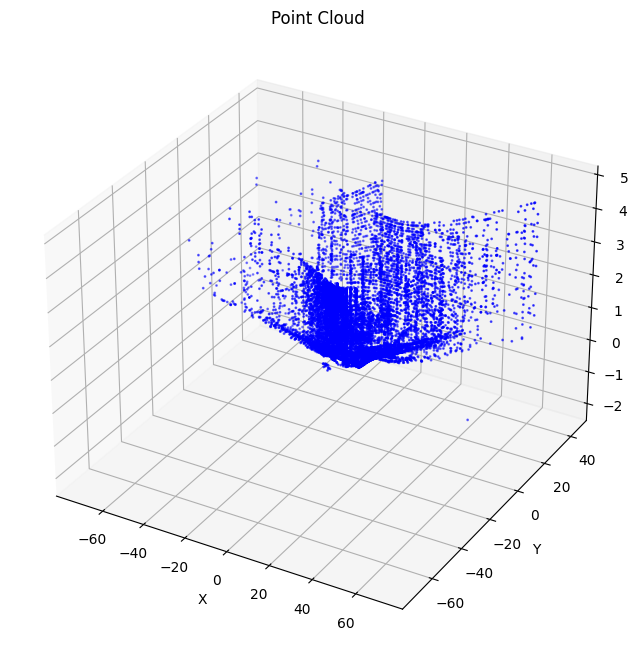

In [14]:
visualize_point_cloud(points[0])

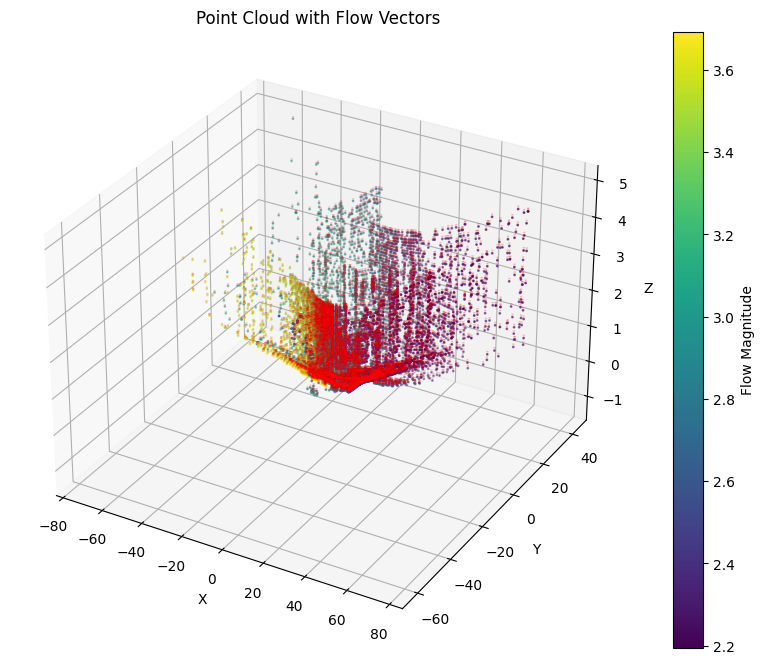

In [12]:
visualize_point_cloud_with_flow(points[0], flow[0], sample_rate=10)

In [21]:
# Save flow and point cloud into two numpy file
np.save('flow2.npy', flow)
np.save('points2.npy', points)

5
Unique values in cp_points_all[..., 0]: [0 1 2 3 4 5]
Unique values of image.name: [1 2 3 4 5]
Distribution of cp_points_all[..., 0]: {0: 70963, 1: 21394, 2: 18348, 3: 20908, 4: 24895, 5: 20393}
Points shape: (176901, 3)
Colors shape: (176901, 3)


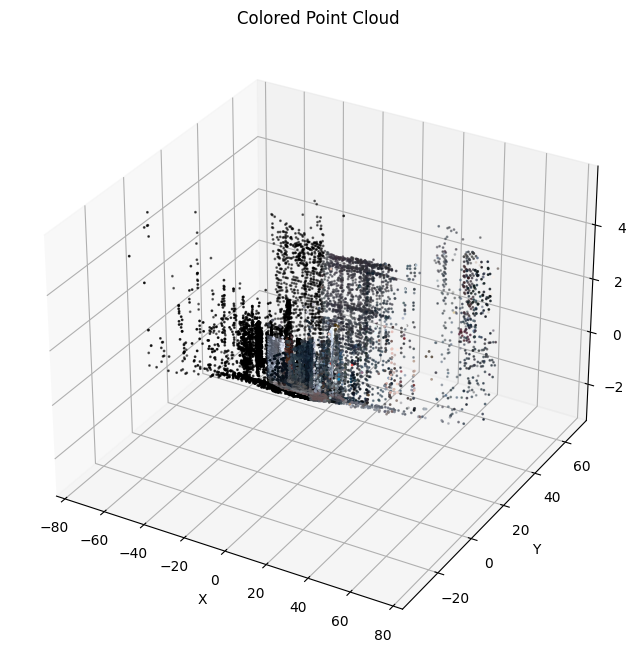

In [13]:
def create_lidar_and_color(frame):
    # Parse range images and camera projections
    (range_images, camera_projections, _, range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(frame)
    
    # Convert range images to point cloud
    points, cp_points = frame_utils.convert_range_image_to_point_cloud(
        frame, range_images, camera_projections, range_image_top_pose, keep_polar_features=False
    )
    points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
        frame, range_images, camera_projections, range_image_top_pose, ri_index=1, keep_polar_features=False
    )
    
    # Concatenate points from both returns
    points_all = np.concatenate(points, axis=0)
    points_all_ri2 = np.concatenate(points_ri2, axis=0)
    points_all = np.concatenate([points_all, points_all_ri2], axis=0)
    
    # Concatenate camera projections from both returns
    cp_points_all = np.concatenate(cp_points, axis=0)
    cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)
    cp_points_all = np.concatenate([cp_points_all, cp_points_all_ri2], axis=0)
    
    
    images = sorted(frame.images, key=lambda i: i.name)
    print(len(images))
    masks = []
    for image in images:
        mask = tf.equal(cp_points_all[..., 0], image.name)
        masks.append(mask)
    unique_cp_points_all = np.unique(cp_points_all[..., 0])
    unique_image_names = np.unique([image.name for image in images])
    
    print("Unique values in cp_points_all[..., 0]:", unique_cp_points_all)
    print("Unique values of image.name:", unique_image_names)
    # Print the distribution of cp_points_all[..., 0]
    unique, counts = np.unique(cp_points_all[..., 0], return_counts=True)
    distribution = dict(zip(unique, counts))
    print("Distribution of cp_points_all[..., 0]:", distribution)
    # Decode all JPEG images
    decoded_images = [tf.image.decode_jpeg(img.image) for img in images]
    
    #build the color tensor
    color_tensor = tf.zeros((cp_points_all.shape[0], 3))
    
    for mask, image in zip(masks, decoded_images):
        cp_points_all_tensor_image = tf.cast(tf.gather_nd(cp_points_all, tf.where(mask)), dtype=tf.float32)
        #convert the cp_points_all_tensor_image to integer indices
        pixel_x = tf.cast(cp_points_all_tensor_image[..., 1], tf.int32)
        pixel_y = tf.cast(cp_points_all_tensor_image[..., 2], tf.int32)
        rgb_values = tf.gather_nd(image, tf.stack([pixel_y, pixel_x], axis=-1))
        # Convert RGB values from 0-255 to 0-1 range
        rgb_values = tf.cast(rgb_values, tf.float32) / 255.0
        color_tensor = tf.tensor_scatter_nd_update(color_tensor, tf.where(mask), rgb_values)
    
    return points_all, color_tensor.numpy()

# Usage example:
_, colors = create_lidar_and_color(frame)
print(f"Points shape: {points.shape}")
print(f"Colors shape: {colors.shape}")

# Visualize the colored point cloud
def visualize_colored_point_cloud(points, colors, sample_rate=10):
    # Sample points to reduce clutter
    sampled_indices = np.random.choice(points.shape[0], points.shape[0] // sample_rate, replace=False)
    sampled_points = points[sampled_indices]
    sampled_colors = colors[sampled_indices]

    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot points
    ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], 
               c=sampled_colors, s=1)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Colored Point Cloud')

    plt.show()

visualize_colored_point_cloud(points, colors)

In [14]:
# Save the color and point cloud as two npy files
np.save('pointdemo1.npy', points)
np.save('colorsdemo1.npy', colors)
np.save('flowdemo1.npy', flow)

In [ ]:
checkpoint="/media/staging2/dhwang/sam2/checkpoints/sam2.1_hiera_small.pt"
model_cfg = "sam2.1_hiera_s.yaml"
device = torch.device(f"cuda:{config.torch_gpu}")
print(f"Using PyTorch device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs
    if torch.cuda.get_device_properties(config.torch_gpu).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

sam2_model = build_sam2(model_cfg, checkpoint, device=device, apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

def create_lidar_masks(frame, mask_generator):
    """Get SAM masks for each point in the point cloud.
    
    Args:
        frame: Waymo frame
        mask_generator: SAM2 mask generator
        
    Returns:
        mask_values: Array of shape (N,) containing mask ID for each point
    """
    # Get regular data first
    (
        range_images,
        camera_projections,
        _,
        range_image_top_pose,
    ) = frame_utils.parse_range_image_and_camera_projection(frame)

    points, cp_points = frame_utils.convert_range_image_to_point_cloud(
        frame,
        range_images,
        camera_projections,
        range_image_top_pose,
        keep_polar_features=True,
    )
    points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
        frame,
        range_images,
        camera_projections,
        range_image_top_pose,
        ri_index=1,
        keep_polar_features=True,
    )

    # Concatenate points from both returns
    points_all = np.concatenate(points + points_ri2)
    cp_points_all = np.concatenate(cp_points + cp_points_ri2)

    images = sorted(frame.images, key=lambda i: i.name)
    masks = []
    sam_masks = []
    
    # Generate SAM masks for each camera image
    for image in images:
        decoded_image = tf.image.decode_jpeg(image.image).numpy()
        mask = create_sam_masks(decoded_image, mask_generator)
        sam_masks.append(mask)
        masks.append(tf.equal(cp_points_all[..., 0], image.name))

    # Project SAM masks to point cloud
    mask_tensor = tf.zeros((cp_points_all.shape[0],), dtype=tf.int32)
    
    for mask, sam_mask, image in zip(masks, sam_masks, images):
        cp_points_image = tf.cast(tf.gather_nd(cp_points_all, tf.where(mask)), dtype=tf.int32)
        pixel_x = cp_points_image[..., 1]
        pixel_y = cp_points_image[..., 2]
        
        # Get mask values for each projected point
        mask_values = tf.gather_nd(sam_mask, tf.stack([pixel_y, pixel_x], axis=-1))
        mask_tensor = tf.tensor_scatter_nd_update(
            mask_tensor, tf.where(mask), mask_values
        )

    mask_values = mask_tensor.numpy()
    return mask_values

# Example usage:
masks = create_lidar_masks(frame, mask_generator)
print(f"Mask values shape: {masks.shape}")
